##### What's uplift modeling
Based on the actions taken by customers with an intervention(ex: offer), there is a fundamental segmentation that separates customers into four following groups. <b>The Persudables</b>, customers who only order because of discounting. <b>The Sure Things</b>, customers who would have ordered whether they were given discounting or not. <b>The Lost Causes</b>, customers who will not order whether given a discount or not.<b> The Do Not Disturbs</b>, customers who are less likely to order because there were given discounts. The Objective of this exercise is to identify The Persuadables, by uplift modeling techniques.

<b>Solutioning framework:</b> The generic framework for incremental value(uplift) modeling is through causal risk difference modeling <b><i>P( Order/Offer=Yes, X ) - P( Order/Offer=No, X )</i></b>. There are various approaches through which we can model incremental value like Single Model Approach (S-Learner), Two Model Approach (T-Learner), X-Learner and Transformed Outcome Approach (TOA). 

The details of above techniques are explored in the following sections with <a href='https://ailab.criteo.com/criteo-uplift-prediction-dataset/'>crieto uplift prediction dataset.</a>


In [1]:
import pandas as pd


from pylift import TransformedOutcome
import numpy as np

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import math



import matplotlib.pyplot as plt
import subprocess
import sys

from pylift import TransformedOutcome
from pylift.eval import UpliftEval
import random
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import contingency_matrix
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [2]:
df = pd.read_csv('/Users/viswanath.g/Downloads/criteo-uplift-v2.1.csv')

In [3]:
print(df.agg({'treatment':['mean'], 'visit':['mean'], 'conversion':['mean']}))
print(df.groupby(['treatment']).agg({'conversion':['mean'], 'visit':['mean'], }))
print(df.groupby(['treatment', 'exposure']).agg({'conversion':['mean', 'count'], 'visit':['mean', 'count'], }))

      treatment     visit  conversion
mean       0.85  0.046992    0.002917
          conversion     visit
                mean      mean
treatment                     
0           0.001938  0.038201
1           0.003089  0.048543
                   conversion               visit          
                         mean     count      mean     count
treatment exposure                                         
0         0          0.001938   2096937  0.038201   2096937
1         0          0.001194  11454443  0.034861  11454443
          1          0.053784    428212  0.414538    428212


In [4]:
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

##### Two Model Approach

q2_aqini:  0.092 q2_qini:  0.111 q2_cgains:  0.089


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

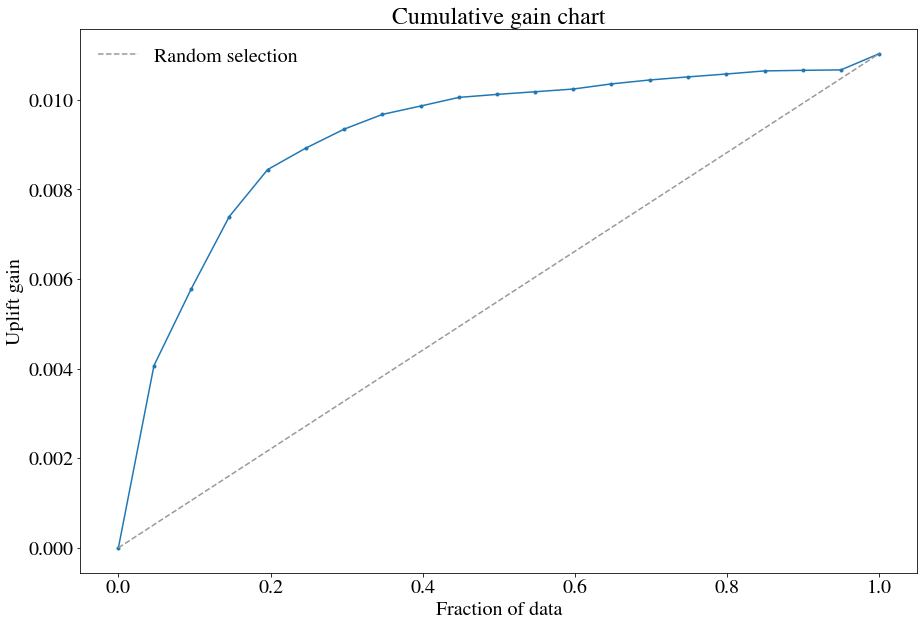

In [5]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

q2_aqini:  0.131 q2_qini:  0.143 q2_cgains:  0.126


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

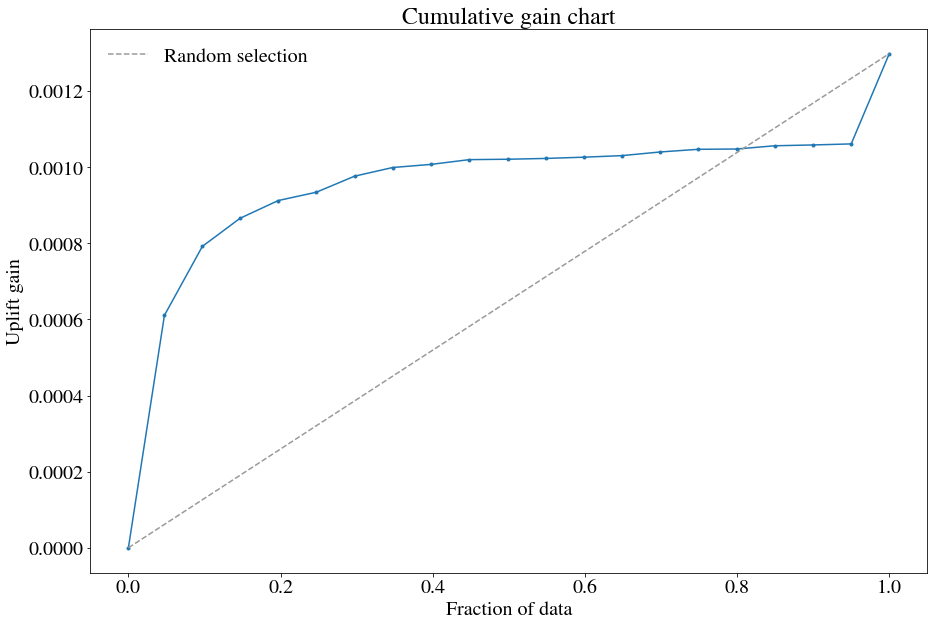

In [6]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

##### One Model Approach

q2_aqini:  0.092 q2_qini:  0.114 q2_cgains:  0.09


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

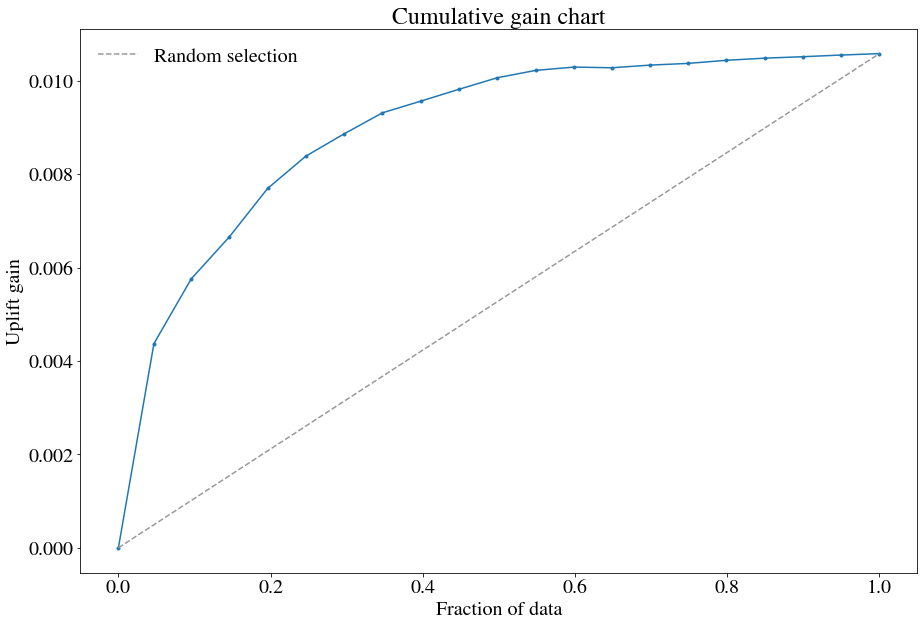

In [7]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 
df_sample[f'{treatmentCol}_mod'] = df_sample[treatmentCol]

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


q2_aqini:  0.006 q2_qini:  0.006 q2_cgains:  0.006


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

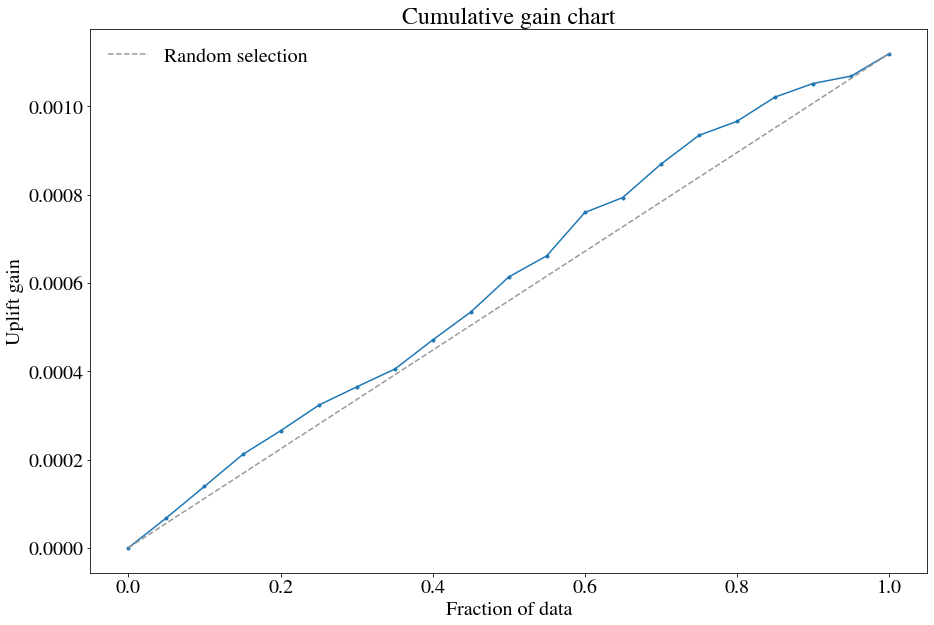

In [8]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 
df_sample[f'{treatmentCol}_mod'] = df_sample[treatmentCol]

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


##### Class Transformation Approach

Propensity Score Model is Built
q2_aqini:  0.082 q2_qini:  0.103 q2_cgains:  0.08


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

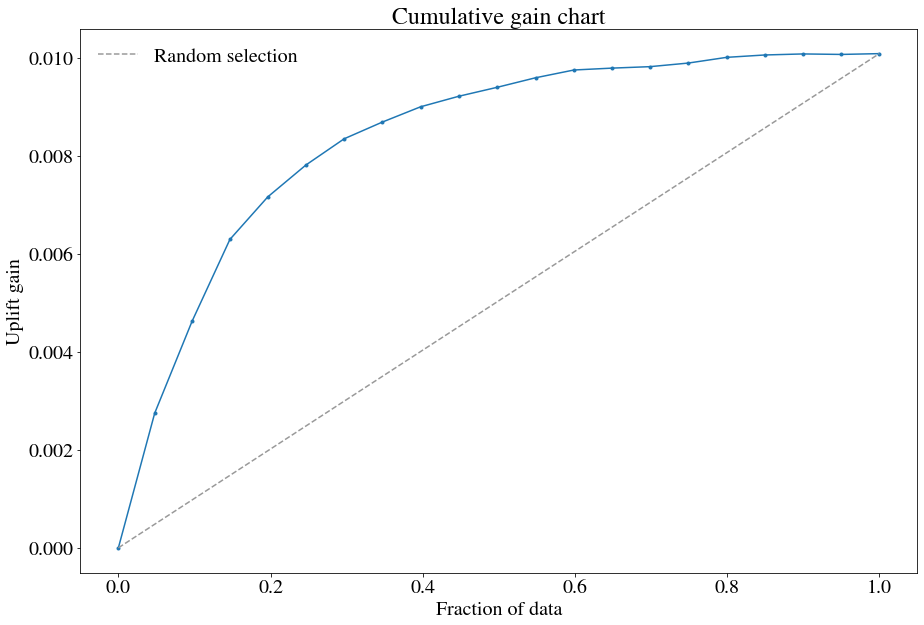

In [9]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

propensityScore = psModel.predict_proba( df_sample[features] )
df_sample['ps'] = np.where(df_sample[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

df_sample['y_mod']  = ( 
                        df_sample[outcomeCol] * ( df_sample[treatmentCol] - df_sample['ps']) 
                                   / 
                       ( df_sample['ps'] * ( 1-df_sample['ps'] ) )
                      )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


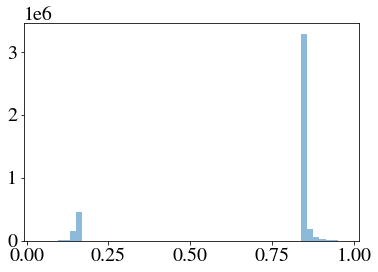

In [10]:
# propensity score distribution
_ = plt.hist(df_sample['ps'], bins=50, alpha=0.5)
# below distributions clearly tells us that the data generates by Incrementality tests

Propensity Score Model is Built
q2_aqini:  0.171 q2_qini:  0.194 q2_cgains:  0.165


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

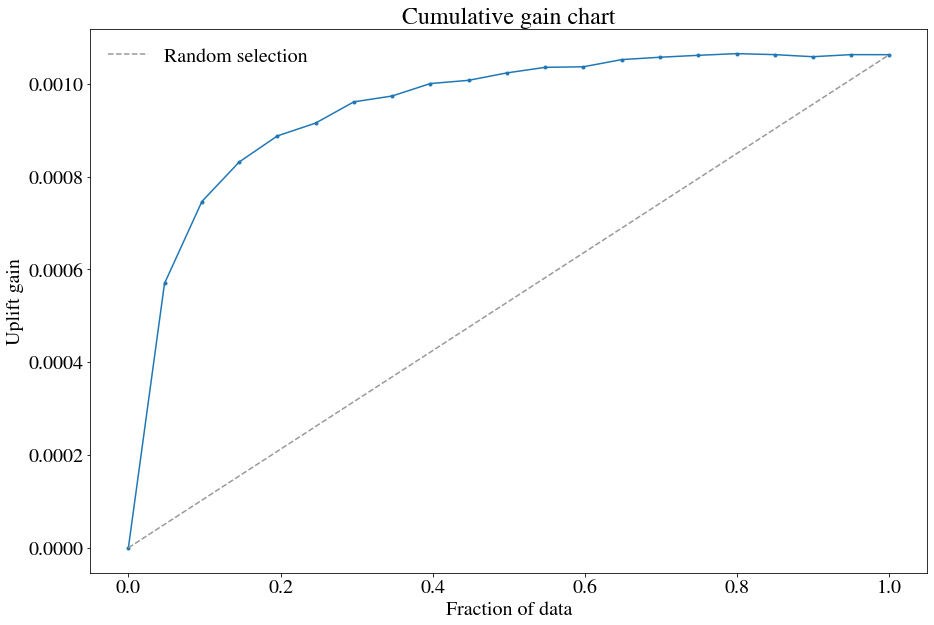

In [11]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

propensityScore = psModel.predict_proba( df_sample[features] )
df_sample['ps'] = np.where(df_sample[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

df_sample['y_mod']  = ( 
                        df_sample[outcomeCol] * ( df_sample[treatmentCol] - df_sample['ps']) 
                                   / 
                       ( df_sample['ps'] * ( 1-df_sample['ps'] ) )
                      )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


##### X-Learner

More details can on X-Learner can be found <a href='https://doordash.engineering/2020/09/18/causal-modeling-to-get-more-value-from-flat-experiment-results/comment-page-1/?unapproved=16&moderation-hash=7fa9a26e6386c27d25dbca6d1c777441#comments'>here</a>

<ipython-input-12-92ac2b29841e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
<ipython-input-12-92ac2b29841e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]


q2_aqini:  0.087 q2_qini:  0.11 q2_cgains:  0.084


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

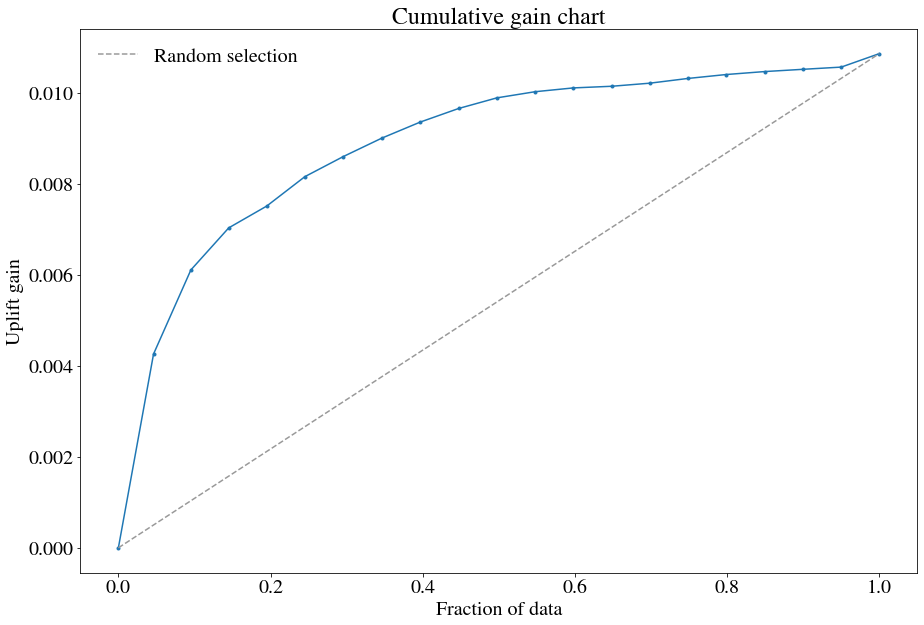

In [12]:

outcomeCol   = 'visit'
treatmentCol = 'treatment'
df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

                
                     

<ipython-input-13-adb95397ae9a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
<ipython-input-13-adb95397ae9a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]


q2_aqini:  0.167 q2_qini:  0.187 q2_cgains:  0.162


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

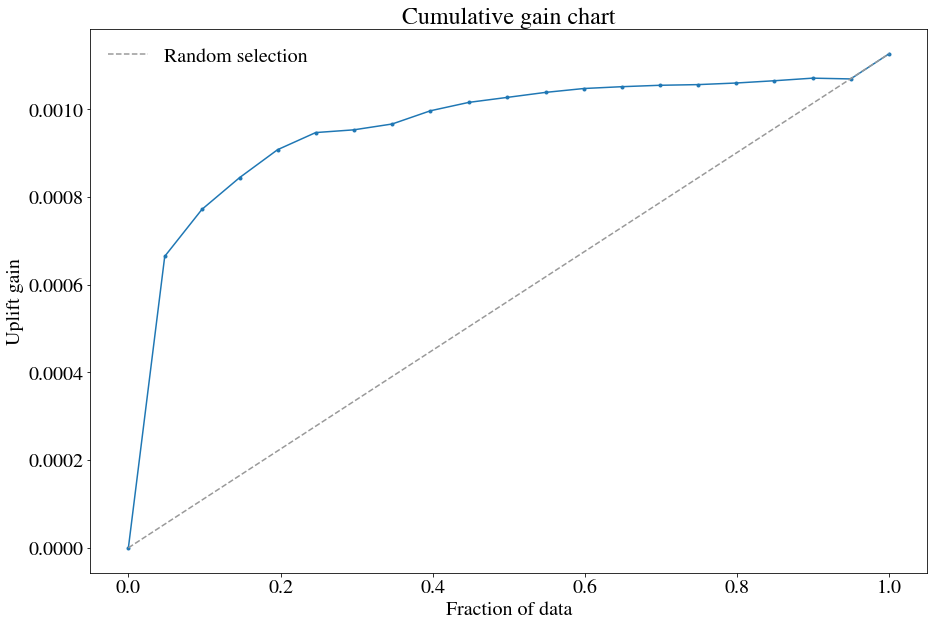

In [13]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'
df_sample = df.sample(frac =.3) 
# df_sample.drop(['conversion', 'exposure'], inplace=True, axis=1)

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

                
                     

##### Two Model Approach

q2_aqini:  0.803 q2_qini:  0.927 q2_cgains:  0.548


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

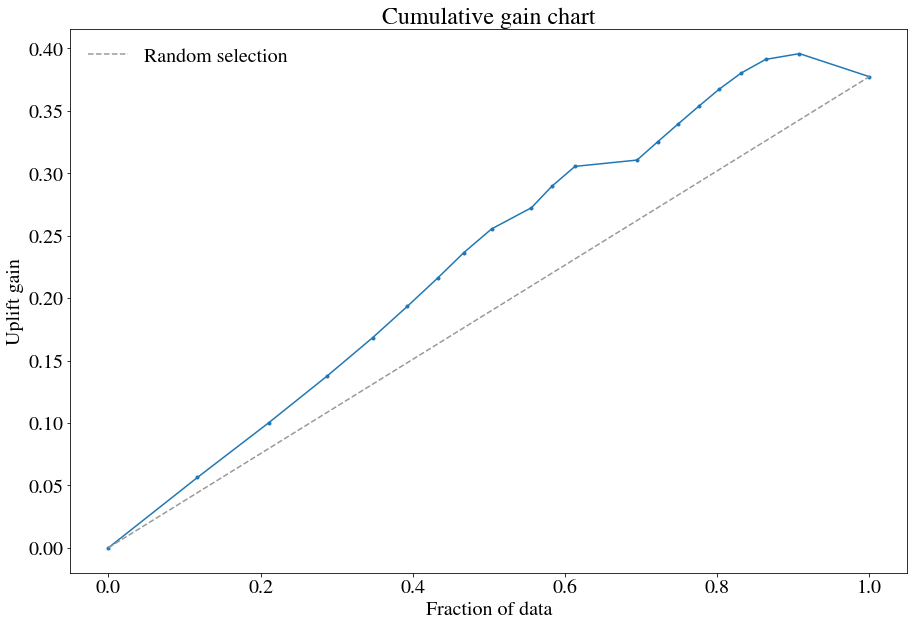

In [14]:

outcomeCol   = 'visit'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

q2_aqini:  0.313 q2_qini:  0.326 q2_cgains:  0.248


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

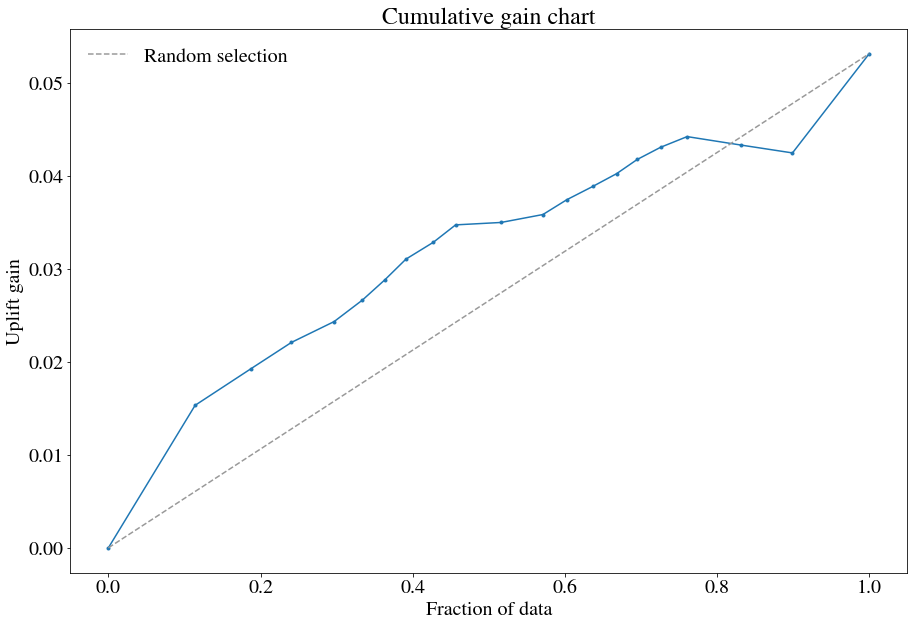

In [15]:

outcomeCol   = 'conversion'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

###### One Model Approach

q2_aqini:  0.827 q2_qini:  0.979 q2_cgains:  0.511


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

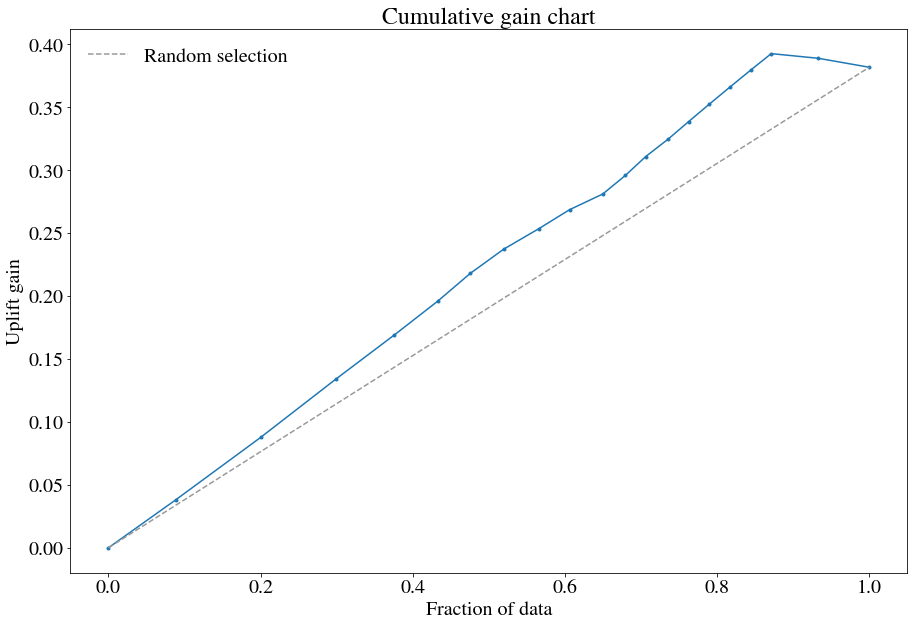

In [16]:
outcomeCol   = 'visit'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 
df_sample[f'{treatmentCol}_mod'] = df_sample[treatmentCol]

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


q2_aqini:  0.55 q2_qini:  0.591 q2_cgains:  0.274


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

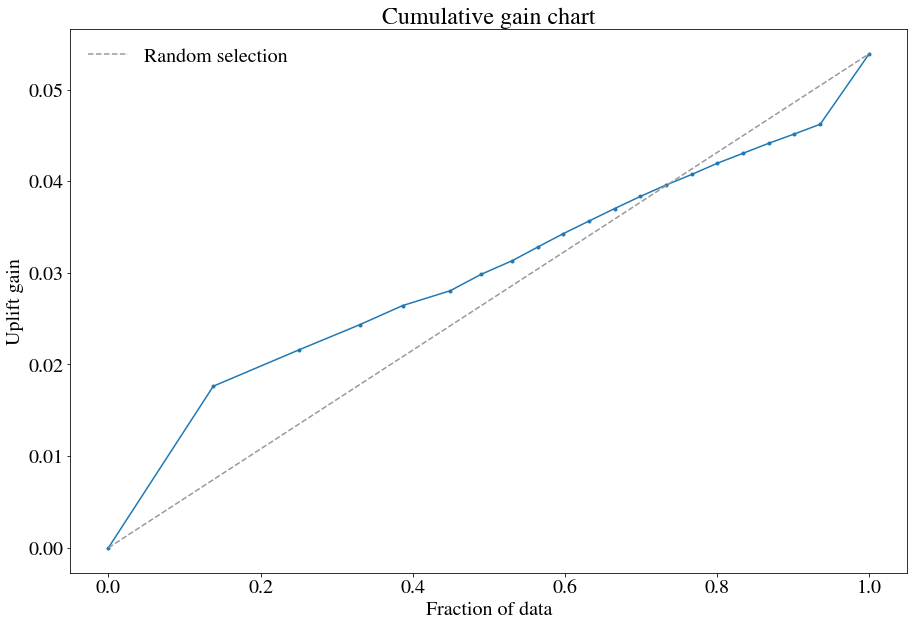

In [17]:
outcomeCol   = 'conversion'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 
df_sample[f'{treatmentCol}_mod'] = df_sample[treatmentCol]

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


##### Class Transformation Approach

Propensity Score Model is Built
q2_aqini:  0.091 q2_qini:  0.107 q2_cgains:  -0.035


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

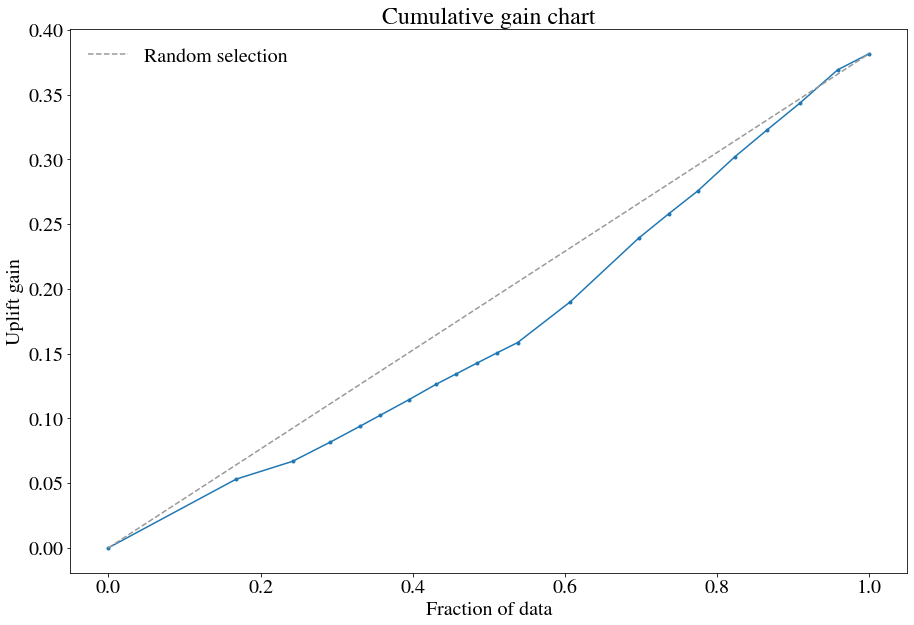

In [18]:
outcomeCol   = 'visit'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

propensityScore = psModel.predict_proba( df_sample[features] )
df_sample['ps'] = np.where(df_sample[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

df_sample['y_mod']  = ( 
                        df_sample[outcomeCol] * ( df_sample[treatmentCol] - df_sample['ps']) 
                                   / 
                       ( df_sample['ps'] * ( 1-df_sample['ps'] ) )
                      )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


Propensity Score Model is Built
q2_aqini:  0.449 q2_qini:  0.467 q2_cgains:  0.196


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

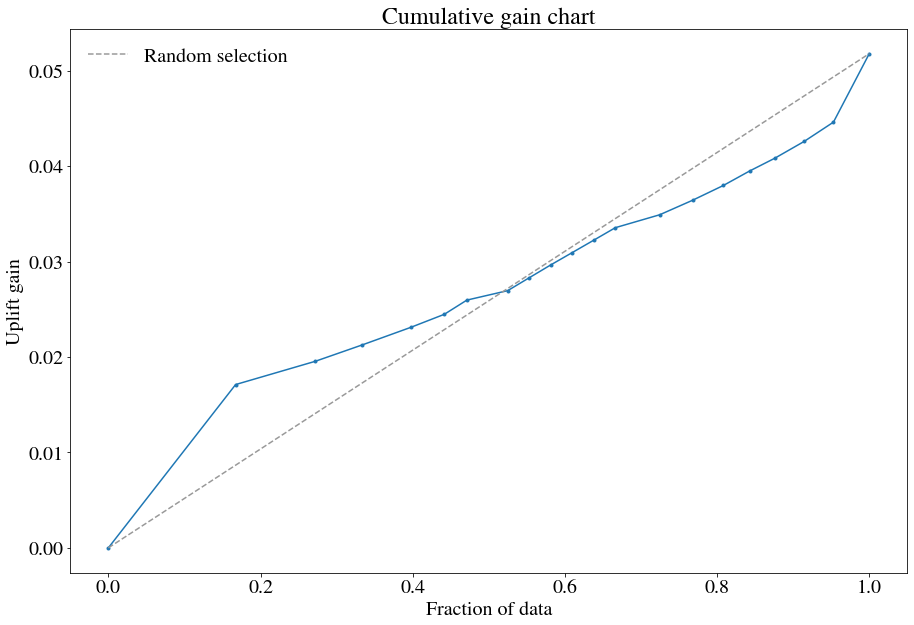

In [19]:
outcomeCol   = 'conversion'
treatmentCol = 'exposure'

df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

propensityScore = psModel.predict_proba( df_sample[features] )
df_sample['ps'] = np.where(df_sample[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

df_sample['y_mod']  = ( 
                        df_sample[outcomeCol] * ( df_sample[treatmentCol] - df_sample['ps']) 
                                   / 
                       ( df_sample['ps'] * ( 1-df_sample['ps'] ) )
                      )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')


##### X-Regressor

<ipython-input-20-088a334771cf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
<ipython-input-20-088a334771cf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]


q2_aqini:  0.888 q2_qini:  1.192 q2_cgains:  0.407


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

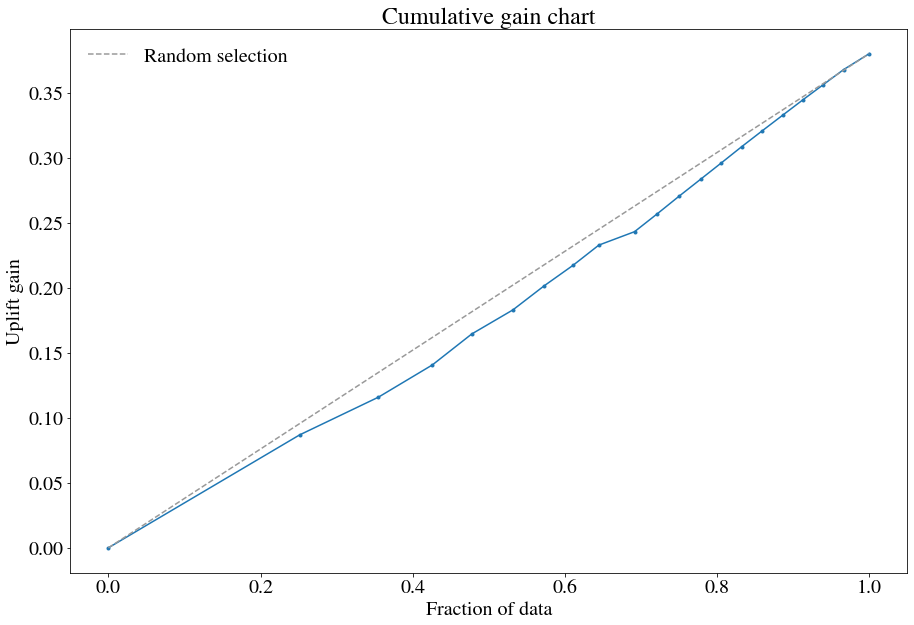

In [20]:

outcomeCol   = 'visit'
treatmentCol = 'exposure'
df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

                
                     

<ipython-input-21-0d6e6bae15eb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
<ipython-input-21-0d6e6bae15eb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]


q2_aqini:  0.6 q2_qini:  0.66 q2_cgains:  0.251


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

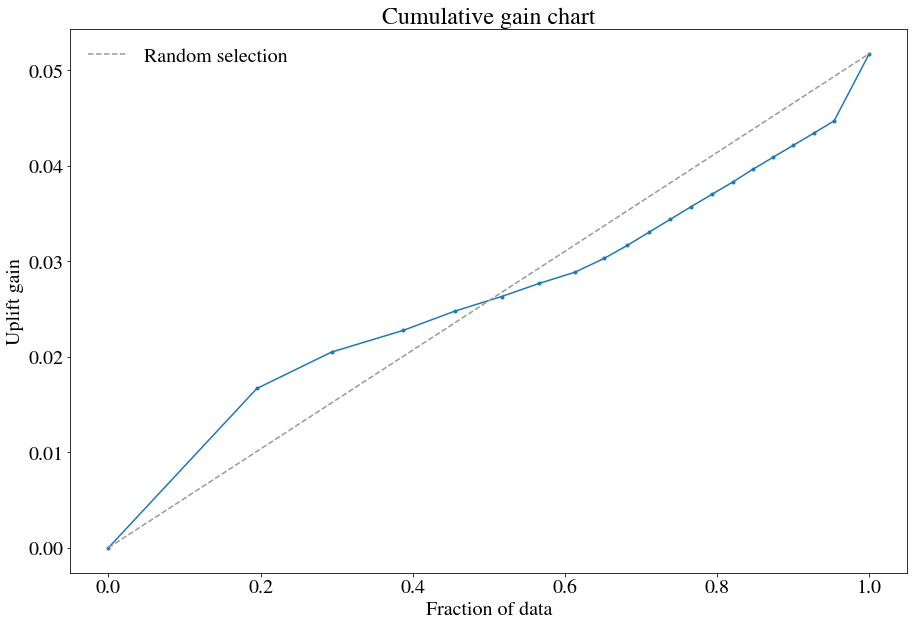

In [21]:

outcomeCol   = 'conversion'
treatmentCol = 'exposure'
df_sample = df.sample(frac =.3) 

psModel = GradientBoostingClassifier().fit( df_sample[features], df_sample[treatmentCol]  )

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains')

                
                     

###### Resources

- <a href='https://doordash.engineering/2020/09/18/causal-modeling-to-get-more-value-from-flat-experiment-results/comment-page-1/?unapproved=16&moderation-hash=7fa9a26e6386c27d25dbca6d1c777441#comments'>Leveraging Causal Modeling to Get More Value from Flat Experiment Results</a>
- <a href='https://pypi.org/project/pylift/'>pylift package</a>
- <a href=''>scikit-uplift</a>